In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

In [2]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.15.0'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path = "/content/gdrive/MyDrive/LAMIA/Botcamp/Card-20/Material.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [6]:
base_imgs = 'Material/fer2013.zip'
zip_object = zipfile.ZipFile(file = base_imgs, mode = 'r')
zip_object.extractall('./')
zip_object.close

<bound method ZipFile.close of <zipfile.ZipFile filename='Material/fer2013.zip' mode='r'>>

In [8]:
data = pd.read_csv('fer2013/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


Text(0.5, 1.0, 'Imagens x emoções')

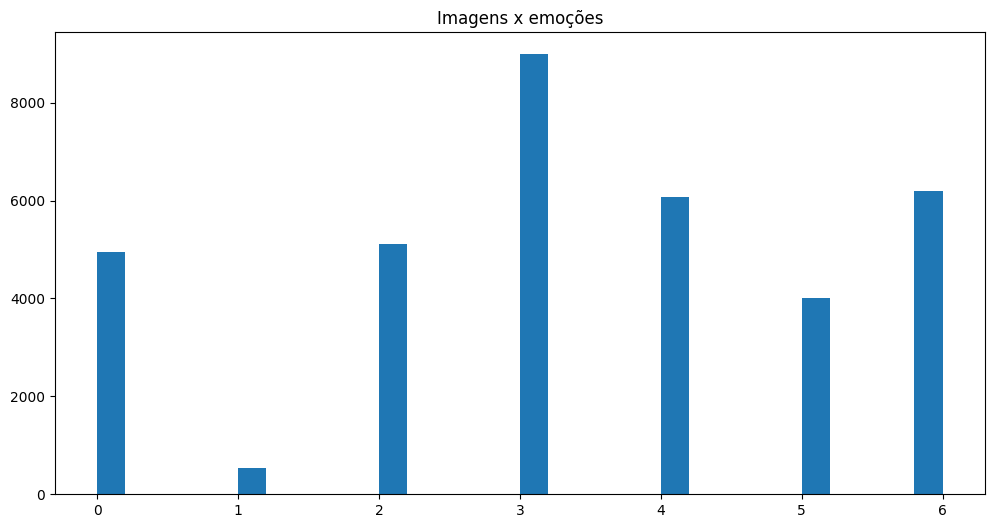

In [9]:
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins = 30)
plt.title('Imagens x emoções')

# Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Etapa 4 - Pré-processamento

In [10]:
pixels = data['pixels'].tolist()
pixels

Output hidden; open in https://colab.research.google.com to view.

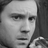

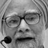

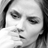

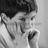

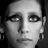

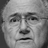

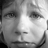

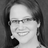

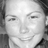

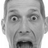

In [11]:
largura, altura = 48, 48
faces = []
amostras = 0
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(largura, altura)
  faces.append(face)

  if (amostras < 10):
    cv2_imshow(face)
  amostras += 1

In [12]:
print(f'Número total de imagens no dataset: {len(faces)}') # MAIS BONITOOOO

#print('Número total de imagens no dataset: ', str(len(faces))) #Original

Número total de imagens no dataset: 35887


In [13]:
faces = np.asarray(faces)

In [14]:
faces.shape

(35887, 48, 48)

In [15]:
faces = np.expand_dims(faces, -1)
faces.shape

(35887, 48, 48, 1)

In [16]:
def normalizar(x):
  x = x.astype('float32')
  x = x / 255.0
  return x

In [17]:
faces = normalizar(faces)

In [18]:
faces[0]

array([[[0.27450982],
        [0.3137255 ],
        [0.32156864],
        ...,
        [0.20392157],
        [0.16862746],
        [0.16078432]],

       [[0.25490198],
        [0.23921569],
        [0.22745098],
        ...,
        [0.21960784],
        [0.20392157],
        [0.17254902]],

       [[0.19607843],
        [0.16862746],
        [0.21176471],
        ...,
        [0.19215687],
        [0.21960784],
        [0.18431373]],

       ...,

       [[0.35686275],
        [0.25490198],
        [0.16470589],
        ...,
        [0.28235295],
        [0.21960784],
        [0.16862746]],

       [[0.3019608 ],
        [0.32156864],
        [0.30980393],
        ...,
        [0.4117647 ],
        [0.27450982],
        [0.18039216]],

       [[0.3019608 ],
        [0.28235295],
        [0.32941177],
        ...,
        [0.41568628],
        [0.42745098],
        [0.32156864]]], dtype=float32)

In [19]:
emocoes = pd.get_dummies(data['emotion']).values

In [20]:
emocoes[0]

array([1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

In [22]:
X_train, X_test, y_train, y_test = train_test_split(faces, emocoes, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 41)

In [23]:
print('Número de imagens no conjunto de treinamento:', len(X_train))
print('Número de imagens no conjunto de teste:', len(X_test))
print('Número de imagens no conjunto de validação:', len(X_val))

Número de imagens no conjunto de treinamento: 29068
Número de imagens no conjunto de teste: 3589
Número de imagens no conjunto de validação: 3230


In [24]:
np.save('mod_xtest', X_test)
np.save('mod_ytest', y_test)

In [25]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
                 input_shape=(width, height, 1), data_format = 'channels_last',
                 kernel_regularizer = l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [ ]:
num_features = 32
num_classes = 7
width, height = 48, 48
batch_size = 16
epochs = 100

model = Sequential()

model.add(Conv2D(num_features, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, (3, 3), padding = "same", kernel_initializer="he_normal",
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0

In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       5

In [ ]:
from tensorflow.keras import optimizers
epochs = 100
batch_size = 64
learning_rate = 0.001

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
adam = optimizers.Adam(lr = learning_rate)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_11 (Batc (None, 23, 23, 128)      

In [ ]:
batch_size = 256
epochs = 100
width, height = 48, 48
num_labels = 7

model = Sequential()

model.add(Conv2D(20, (3, 3), padding='same', activation='relu', input_shape=(width, height, 1)))
model.add(Conv2D(30, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(60, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(70, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(80, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(90, (3, 3), padding='same', activation='relu'))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(512, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 20)        200       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 30)        5430      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 30)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 30)        120       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 40)        10840     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 50)        1

Parâmetros Adam: https://arxiv.org/abs/1412.6980

Artigo Adam: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

beta: Taxa de decaimento exponencial (por exemplo, 0.9)

In [26]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics = ['accuracy'])

arquivo_modelo = 'modelo_01_expressoes.h5'
arquivo_modelo_json = 'modelo_01_expressoes.json'

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience=3, verbose = 1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose = 1, save_best_only=True)

In [27]:
model_json = model.to_json()
with open(arquivo_modelo_json, 'w') as json_file:
  json_file.write(model_json)

In [28]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (np.array(X_val), np.array(y_val)),
                    shuffle=True,
                    callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/100
455/455 [==============================] - ETA: 0s - loss: 1.9923 - accuracy: 0.2171
Epoch 1: val_loss improved from inf to 1.80533, saving model to modelo_01_expressoes.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


455/455 [==============================] - 40s 59ms/step - loss: 1.9923 - accuracy: 0.2171 - val_loss: 1.8053 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 2/100
454/455 [============================>.] - ETA: 0s - loss: 1.8406 - accuracy: 0.2447
Epoch 2: val_loss did not improve from 1.80533
455/455 [==============================] - 25s 56ms/step - loss: 1.8406 - accuracy: 0.2447 - val_loss: 1.8054 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 3/100
454/455 [============================>.] - ETA: 0s - loss: 1.8149 - accuracy: 0.2513
Epoch 3: val_loss improved from 1.80533 to 1.77351, saving model to modelo_01_expressoes.h5
455/455 [==============================] - 25s 55ms/step - loss: 1.8150 - accuracy: 0.2513 - val_loss: 1.7735 - val_accuracy: 0.2628 - lr: 0.0010
Epoch 4/100
454/455 [============================>.] - ETA: 0s - loss: 1.7548 - accuracy: 0.2867
Epoch 4: val_loss improved from 1.77351 to 1.74114, saving model to modelo_01_expressoes.h5
455/455 [==============================]

In [29]:
print(history.history)

{'loss': [1.9923228025436401, 1.840598225593567, 1.8149744272232056, 1.7547473907470703, 1.636826515197754, 1.547652006149292, 1.4779695272445679, 1.4299461841583252, 1.3900352716445923, 1.3395174741744995, 1.310880422592163, 1.2908220291137695, 1.2545183897018433, 1.2297037839889526, 1.2036457061767578, 1.183529257774353, 1.1499733924865723, 1.1301755905151367, 1.1102278232574463, 1.082893967628479, 1.0660278797149658, 1.044367790222168, 1.0214704275131226, 1.0051499605178833, 0.9884037375450134, 0.9613913297653198, 0.9414645433425903, 0.9269700646400452, 0.900955080986023, 0.8900560736656189, 0.870399534702301, 0.8495717644691467, 0.8204620480537415, 0.814469575881958, 0.7756815552711487, 0.7715297341346741], 'accuracy': [0.21711160242557526, 0.2447020709514618, 0.25134167075157166, 0.2867414355278015, 0.3450529873371124, 0.3865419030189514, 0.4190174639225006, 0.44746801257133484, 0.46934774518013, 0.4937044084072113, 0.503233790397644, 0.5143800973892212, 0.5318563580513, 0.5436562

## Gerando gráfico da melhora em cada etapa do treinamento

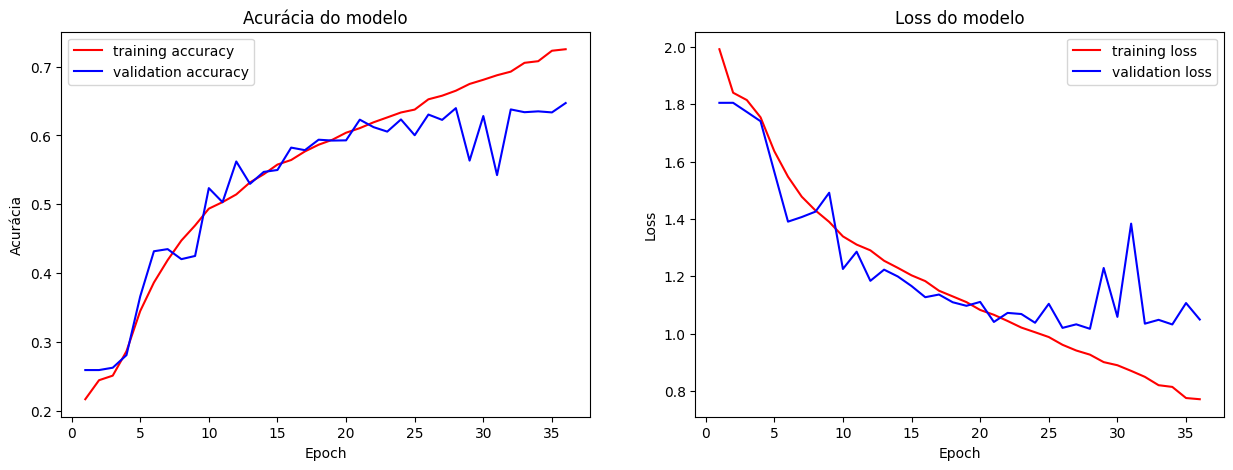

In [30]:
def plota_historico_modelo(historico_modelo):
  fig, axs = plt.subplots(1, 2, figsize=(15,5))
  axs[0].plot(range(1, len(historico_modelo.history['accuracy']) + 1), historico_modelo.history['accuracy'], 'r')
  axs[0].plot(range(1, len(historico_modelo.history['val_accuracy']) + 1), historico_modelo.history['val_accuracy'], 'b')
  axs[0].set_title('Acurácia do modelo')
  axs[0].set_ylabel('Acurácia')
  axs[0].set_xlabel('Epoch')
  #axs[0].set_xticks(np.arange(1, len(historico_modelo.history['accuracy']) + 1),
  #                  len(historico_modelo.history['accuracy']) / 10)
  axs[0].legend(['training accuracy', 'validation accuracy'], loc = 'best')

  axs[1].plot(range(1, len(historico_modelo.history['loss']) + 1), historico_modelo.history['loss'], 'r')
  axs[1].plot(range(1, len(historico_modelo.history['val_loss']) + 1), historico_modelo.history['val_loss'], 'b')
  axs[1].set_title('Loss do modelo')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  #axs[1].set_xticks(np.arange(1, len(historico_modelo.history['loss']) + 1),
  #                  len(historico_modelo.history['loss']) / 10)
  axs[1].legend(['training loss', 'validation loss'], loc = 'best')
  fig.savefig('historico_modelo_mod01.png')

plota_historico_modelo(history)

### Verificando a acurácia do modelo

In [31]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size = batch_size)

57/57 [==============================] - 1s 21ms/step - loss: 1.0889 - accuracy: 0.6330


In [32]:
scores

[1.08888578414917, 0.6330454349517822]

In [33]:
print(f'Acurácia: {scores[1]}')
print(f'Erro: {scores[0]}')

Acurácia: 0.6330454349517822
Erro: 1.08888578414917


## Carregamento dos dados para gerar a matriz de confusão

In [34]:
true_y = []
pred_y = []
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')

In [35]:
x[0]

array([[[0.5568628 ],
        [0.5803922 ],
        [0.59607846],
        ...,
        [0.3529412 ],
        [0.3529412 ],
        [0.3647059 ]],

       [[0.5568628 ],
        [0.5764706 ],
        [0.5921569 ],
        ...,
        [0.33333334],
        [0.36078432],
        [0.40392157]],

       [[0.5529412 ],
        [0.5686275 ],
        [0.5921569 ],
        ...,
        [0.3372549 ],
        [0.32156864],
        [0.37254903]],

       ...,

       [[0.0627451 ],
        [0.08235294],
        [0.07058824],
        ...,
        [0.08235294],
        [0.09019608],
        [0.11372549]],

       [[0.05490196],
        [0.0627451 ],
        [0.05490196],
        ...,
        [0.07450981],
        [0.07843138],
        [0.09803922]],

       [[0.04705882],
        [0.04705882],
        [0.04705882],
        ...,
        [0.06666667],
        [0.07450981],
        [0.09411765]]], dtype=float32)

In [36]:
y[0]

array([0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [37]:
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()

In [38]:
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)

In [39]:
y_pred = loaded_model.predict(x)

113/113 [==============================] - 2s 6ms/step


In [40]:
y_pred[0]

array([5.3233940e-02, 5.1644014e-04, 6.0441501e-02, 5.3672278e-01,
       9.1948159e-02, 2.4198640e-02, 2.3293854e-01], dtype=float32)

In [41]:
yp = y_pred.tolist()
yt = y.tolist()
count = 0

In [42]:
len(y)

3589

In [43]:
for i in range(len(y)):
  yy = max(yp[i])
  yyt = max(yt[i])
  pred_y.append(yp[i].index(yy))
  true_y.append(yt[i].index(yyt))
  if (yp[i].index(yy) == yt[i].index(yyt)):
    count += 1

acc = (count / len(y)) * 100

In [44]:
print('Acurácia no conjunto de teste: ' + str(acc))

Acurácia no conjunto de teste: 62.385065477848975


In [45]:
np.save('truey_mod01', true_y)
np.save('predy_mod01', pred_y)

## Gerando a Matriz de Confusão

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
y_true = np.load('truey_mod01.npy')
y_pred = np.load('predy_mod01.npy')

In [48]:
cm = confusion_matrix(y_true, y_pred)
expressoes = ['Raiva', 'Nojo', 'Medo', 'Feliz', 'Triste', 'Surpreso', 'Neutro']
titulo = 'Matriz de Confusão'
print(cm)

[[237   2  26  25  90  13 105]
 [ 33   3   2   0  10   1   3]
 [ 65   1 150  20 159  70  80]
 [ 17   0   9 745  23  37  50]
 [ 31   0  26  36 340   3 152]
 [ 10   0  38  18  10 319  19]
 [ 23   0   5  38  93   7 445]]


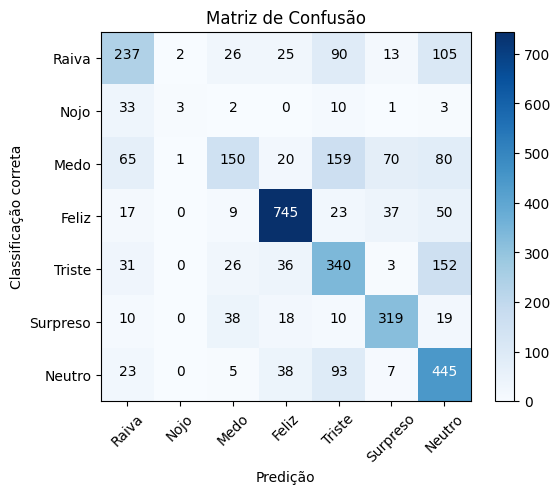

In [50]:
import itertools
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation = 45)
plt.yticks(tick_marks, expressoes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')

plt.ylabel('Classificação correta')
plt.xlabel('Predição')
plt.savefig('matriz_confusao_mod01.png')

## Testando o modelo

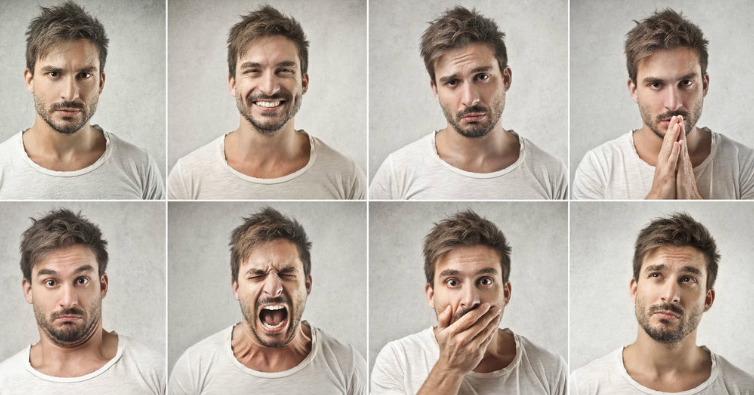

In [51]:
imagem = cv2.imread('Material/testes/teste02.jpg')
cv2_imshow(imagem)

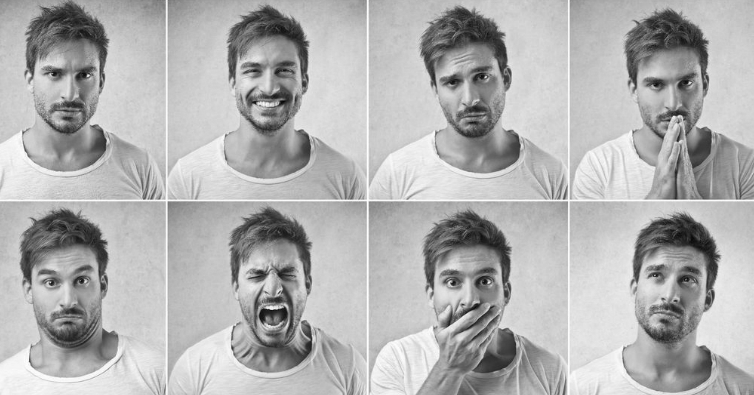

In [52]:
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [53]:
face_cascade = cv2.CascadeClassifier('Material/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)

In [54]:
faces

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

1/1 [==============================] - 0s 29ms/step


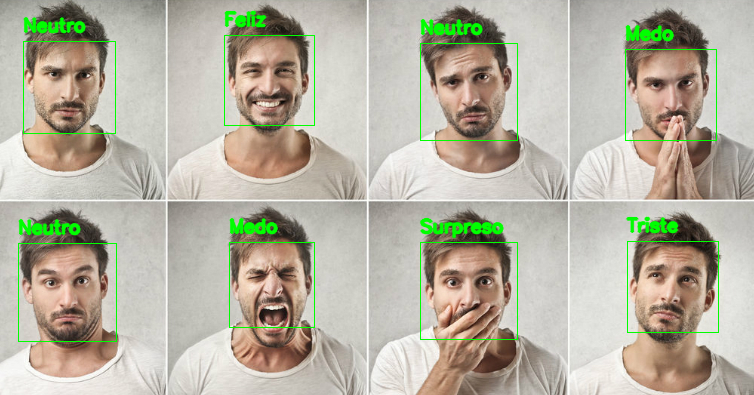

In [55]:
for (x, y, w, h) in faces:
  cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi_gray = gray[y:y + h, x:x + w]
  roi_gray = roi_gray.astype('float') / 255.0
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
  prediction = loaded_model.predict(cropped_img)[0]
  cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

cv2_imshow(original)